In [1]:
# Xử lý dữ liệu & Đại số tuyến tính
import numpy as np
import pandas as pd

# Trực quan hóa dữ liệu
import matplotlib.pyplot as plt
import seaborn as sns

# Học máy
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Util
import logging
import joblib
import warnings
import sys
import os
import random

In [2]:
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("viridis")


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

In [3]:
sys.path.append(os.path.abspath(".."))

from src.train_xgboost import XGBoostManual

In [4]:
X_train = joblib.load("../artifacts/X_train_proc.pkl")
X_test = joblib.load("../artifacts/X_test_proc.pkl")
y_train = joblib.load("../artifacts/y_train.pkl")
y_test = joblib.load("../artifacts/y_test.pkl")

print("✅ Đã load lại dữ liệu thành công!")

✅ Đã load lại dữ liệu thành công!


In [5]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print("Các lớp:", list(le.classes_))
print("Ví dụ y_train:", y_train_encoded[:10])

Các lớp: ['Cloudy', 'Rainy', 'Snowy', 'Sunny']
Ví dụ y_train: [2 2 2 3 3 3 3 2 1 0]


In [ ]:
# model = XGBoostManual(
#     n_classes=len(set(y_train_encoded)),
#     n_estimators=50,
#     learning_rate=0.1,
#     max_depth=3
# )

# model.fit(X_train, y_train_encoded)

# model = XGBoostManual(
#     n_classes=len(le.classes_),
#     n_estimators=50,
#     learning_rate=0.1,
#     max_depth=3
# )


model = XGBoostManual(
    n_classes=len(np.unique(y_train_encoded)),
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.7
)
model.fit(X_train, y_train_encoded)

In [7]:
# Train XGBoost chính thức
xgb_model = XGBClassifier(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    random_state=77,
    objective='multi:softmax',  # phân loại nhiều lớp
    num_class=len(le.classes_)
)
xgb_model.fit(X_train, y_train_encoded)

,objective,'multi:softmax'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [8]:
# Dự đoán trên tập test
y_pred = model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

In [9]:
# Accuracy
acc = accuracy_score(y_test_encoded, y_pred)
acc_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
print(f"🎯 Accuracy: {acc:.4f}")
print(f"🎯 Accuracy (XGBoost Thư viện): {acc_xgb:.4f}")

🎯 Accuracy: 0.9133
🎯 Accuracy (XGBoost Thư viện): 0.9095


In [10]:
# Báo cáo chi tiết
print("\n📊 Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))
print("\n📊 Classification Report (XGBoost Thư viện):")
print(classification_report(y_test_encoded, y_pred_xgb, target_names=le.classes_))


📊 Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.87      0.91      0.89       660
       Rainy       0.90      0.92      0.91       660
       Snowy       0.96      0.91      0.93       660
       Sunny       0.93      0.92      0.93       660

    accuracy                           0.91      2640
   macro avg       0.91      0.91      0.91      2640
weighted avg       0.91      0.91      0.91      2640


📊 Classification Report (XGBoost Thư viện):
              precision    recall  f1-score   support

      Cloudy       0.87      0.90      0.89       660
       Rainy       0.88      0.92      0.90       660
       Snowy       0.96      0.90      0.93       660
       Sunny       0.93      0.92      0.92       660

    accuracy                           0.91      2640
   macro avg       0.91      0.91      0.91      2640
weighted avg       0.91      0.91      0.91      2640



In [11]:
# Ma trận nhầm lẫn
cm = confusion_matrix(y_test_encoded, y_pred)
cm_xgb = confusion_matrix(y_test_encoded, y_pred_xgb)

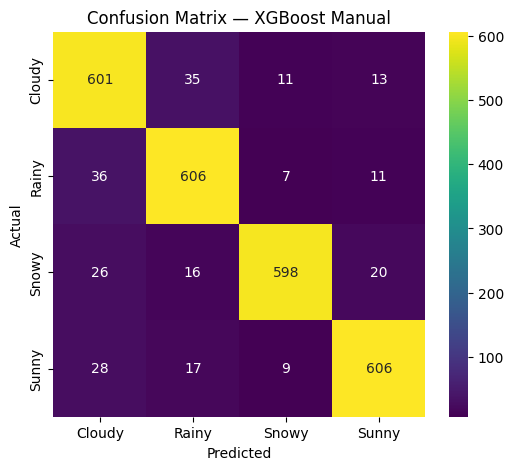

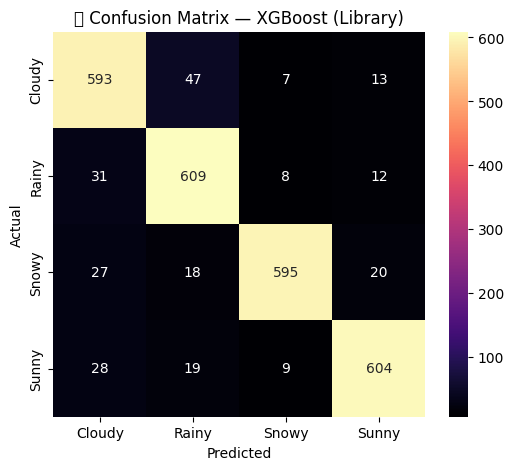

In [12]:
# confusion Matrix 
# Thủ công
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — XGBoost Manual")
plt.show()

# Thư viện
plt.figure(figsize=(6,5))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='magma',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("🔍 Confusion Matrix — XGBoost (Library)")
plt.show()